### Bài toán người du lịch (Traveling Salesman Problem)
Phát biểu: có $N$ thành phố. Một người muốn đi du lịch hết tất cả các thành phố.  
Bắt đầu từ thành phố $0$, đi hết các thành phố $1, 2 .., N-1$ rồi quay về thành phố $0$. Tìm cách đi tốn ít chi phí nhất

Đầu vào:
- Ma trận chi phí 

Đầu ra: 
- Hành trình di chuyển
- Chi phí di chuyển

In [220]:
import numpy as np # type: ignore
import random
import copy
import matplotlib.pyplot as plt # type: ignore

In [221]:
class Problem:
    def __init__(self, matrix):
        self.matrix = matrix
    def get_size(self):
        return self.matrix.shape[0]

In [222]:
def decode(chromosome):
    indices = np.argsort(chromosome)
    solution = np.empty_like(chromosome)
    rank = np.arange(1, len(chromosome) + 1)
    solution[indices] = rank
    return solution.astype(int)

def get_fitness(solution, problem : Problem):
    city = decode(solution)
    cost = problem.matrix
    N = city.size
    total_cost = cost[0][city[0]]
    for i in range(1, N):
        total_cost += cost[city[i - 1]][city[i]]
    total_cost += cost[city[-1]][0]
    return -total_cost

In [ ]:
class Individual:
    def __init__(self):
        self.chromosome = None
        self.fitness = None

    def gen_indi(self, problem : Problem):
        self.chromosome = np.random.uniform(0.0, 1.0, problem.get_size() - 1)
    
    def cal_fitness(self, problem):
        self.fitness = get_fitness(self.chromosome, problem)

    def clone(self):
        return copy.deepcopy(self)
    
    def __repr__(self):
        return f"chromosome={self.chromosome}, fitness={self.fitness}" 


In [224]:
# Simulated binary crossover - SBX
def crossover(parent1, parent2, problem : Problem, eta = 2.0):
    off1 = Individual()
    off2 = Individual()
    r = np.random.rand()
    if (r <= 0.5):
        beta = (2*r)**(1.0/(eta + 1))
    else:
        beta = (1.0/(2*(1 - r)))**(1.0/(eta + 1))
    p1 = parent1.chromosome
    p2 = parent2.chromosome
    c1 = 0.5 * ((1 + beta) * p1 + (1 - beta) * p2)
    c2 = 0.5 * ((1 - beta) * p1 + (1 + beta) * p2)
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    off1.chromosome = c1
    off2.chromosome = c2
    return off1.clone(), off2.clone()

In [225]:

# Polynomial mutaion - PM
def mutation(indi : Individual, eta = 20.0):
    chr = indi.chromosome
    for i in range(chr.size):
        mu = np.random.rand()
        if (mu <= 0.5):
            delta = (2 * mu)**(1.0/(1 + eta)) - 1
            chr[i] = chr[i] + delta * chr[i]
        else:
            delta = 1 - (2 - 2*mu)**(1.0/(1 + eta))
            chr[i] = chr[i] + delta * (1 - chr[i])
            
    chr = np.clip(chr, 0.0, 1.0)
    indi.chromosome = chr
    return indi.clone()

In [ ]:
class Population:
    def __init__(self, pop_size, problem : Problem):
        self.pop_size = pop_size
        self.list_indi = []
        self.problem = problem
    
    def genPop(self):
        for i in range(self.pop_size):
            indi = Individual()
            indi.gen_indi(self.problem)
            indi.cal_fitness(self.problem)
            self.list_indi.append(indi)

    def __repr__(self):
        pass

In [227]:
def selection(list, k = 2):
    tour1 = random.sample(list, k)
    tour2 = random.sample(list, k)
    x = max(tour1, key=lambda indi: indi.fitness)
    y = max(tour2, key=lambda indi: indi.fitness)
    return x.clone(), y.clone() 

In [228]:
def survival_selection(list, pop_size):
    list = sorted(list, key=lambda indi: indi.fitness, reverse=True)
    list = list[0: pop_size]
    return list

In [229]:
def GA(problem, pop_size, max_gen, p_c, p_m):
    pop = Population(pop_size, problem)
    pop.genPop()
    history = []
    for i in range(max_gen):
        child = []
        while (len(child) < pop_size):
            p1, p2 = selection(pop.list_indi)
            if np.random.rand() <= p_c:
                c1, c2 = crossover(p1, p2, problem)
                c1.cal_fitness(problem)
                c2.cal_fitness(problem)
                child.append(c1)
                child.append(c2)
            if np.random.rand() <= p_m:
                p1 = mutation(p1)
                p2 = mutation(p2)
                p1.cal_fitness(problem)
                p2.cal_fitness(problem)
                child.append(p1)
                child.append(p2)
        pop.list_indi = survival_selection(pop.list_indi + child, pop_size)
        history.append(pop.list_indi[0].fitness)
    solution = pop.list_indi[0]
    return history, solution

In [230]:
# setup
# n = np.random.randint(3, 10)
# matrix = []
# for i in range(n):
#     arr = np.random.uniform(0.0, 20.0, n)
#     arr[i] = 0.0
#     matrix.append(arr)
# matrix = np.array(matrix)
matrix = np.array([
    [0, 68, 35, 1, 70, 25, 79, 59, 63, 65, 6, 46, 82, 28, 62],
    [92, 0, 43, 28, 37, 92, 5, 3, 54, 93, 83, 22, 17, 19, 96],
    [48, 27, 0, 39, 70, 13, 68, 100, 36, 95, 4, 12, 23, 34, 74],
    [65, 42, 12, 0, 69, 48, 45, 63, 58, 38, 60, 24, 42, 30, 79],
    [17, 36, 91, 43, 0, 7, 41, 43, 65, 49, 47, 6, 91, 30, 71],
    [51, 7, 2, 94, 49, 0, 24, 85, 55, 57, 41, 67, 77, 32, 9],
    [45, 40, 27, 24, 38, 39, 0, 83, 30, 42, 34, 16, 40, 59, 5],
    [31, 78, 7, 74, 87, 22, 46, 0, 73, 71, 30, 78, 74, 98, 13],
    [87, 91, 62, 37, 56, 68, 56, 75, 0, 53, 51, 51, 42, 25, 67],
    [31, 8, 92, 8, 38, 58, 88, 54, 84, 0, 10, 10, 59, 22, 89],
    [23, 47, 7, 31, 14, 69, 1, 92, 63, 56, 0, 60, 25, 38, 49],
    [84, 96, 42, 3, 51, 92, 37, 75, 21, 97, 22, 0, 100, 69, 85],
    [82, 35, 54, 100, 19, 39, 1, 89, 28, 68, 29, 94, 0, 84, 8],
    [22, 11, 18, 14, 15, 10, 17, 36, 52, 1, 50, 20, 57, 0, 4],
    [25, 9, 45, 10, 90, 3, 96, 86, 94, 44, 24, 88, 15, 4, 0]])

problem = Problem(matrix)
pop_size = 20
max_gen = 500
Pc = 0.9
Pm = 0.1

# start
fitness_history, solution = GA(problem, pop_size, max_gen, Pc, Pm)

#show
for i in range(len(fitness_history)):
    print(f"Generation {i}, bestfitness = {fitness_history[i]:.2f}")

Generation 0, bestfitness = -457.00
Generation 1, bestfitness = -457.00
Generation 2, bestfitness = -438.00
Generation 3, bestfitness = -438.00
Generation 4, bestfitness = -438.00
Generation 5, bestfitness = -393.00
Generation 6, bestfitness = -393.00
Generation 7, bestfitness = -393.00
Generation 8, bestfitness = -383.00
Generation 9, bestfitness = -383.00
Generation 10, bestfitness = -383.00
Generation 11, bestfitness = -383.00
Generation 12, bestfitness = -383.00
Generation 13, bestfitness = -383.00
Generation 14, bestfitness = -383.00
Generation 15, bestfitness = -383.00
Generation 16, bestfitness = -383.00
Generation 17, bestfitness = -383.00
Generation 18, bestfitness = -383.00
Generation 19, bestfitness = -383.00
Generation 20, bestfitness = -383.00
Generation 21, bestfitness = -383.00
Generation 22, bestfitness = -383.00
Generation 23, bestfitness = -383.00
Generation 24, bestfitness = -383.00
Generation 25, bestfitness = -383.00
Generation 26, bestfitness = -383.00
Generation 

In [231]:
np.set_printoptions(precision=2, suppress=True)
print("problem:")
print(matrix)
print()
print("solution:")
print(decode(solution.chromosome))
print(f"total_cost =  {-solution.fitness:.2f}")


problem:
[[  0  68  35   1  70  25  79  59  63  65   6  46  82  28  62]
 [ 92   0  43  28  37  92   5   3  54  93  83  22  17  19  96]
 [ 48  27   0  39  70  13  68 100  36  95   4  12  23  34  74]
 [ 65  42  12   0  69  48  45  63  58  38  60  24  42  30  79]
 [ 17  36  91  43   0   7  41  43  65  49  47   6  91  30  71]
 [ 51   7   2  94  49   0  24  85  55  57  41  67  77  32   9]
 [ 45  40  27  24  38  39   0  83  30  42  34  16  40  59   5]
 [ 31  78   7  74  87  22  46   0  73  71  30  78  74  98  13]
 [ 87  91  62  37  56  68  56  75   0  53  51  51  42  25  67]
 [ 31   8  92   8  38  58  88  54  84   0  10  10  59  22  89]
 [ 23  47   7  31  14  69   1  92  63  56   0  60  25  38  49]
 [ 84  96  42   3  51  92  37  75  21  97  22   0 100  69  85]
 [ 82  35  54 100  19  39   1  89  28  68  29  94   0  84   8]
 [ 22  11  18  14  15  10  17  36  52   1  50  20  57   0   4]
 [ 25   9  45  10  90   3  96  86  94  44  24  88  15   4   0]]

solution:
[ 3  9  1  4 11 10 12 14  5  8 13 

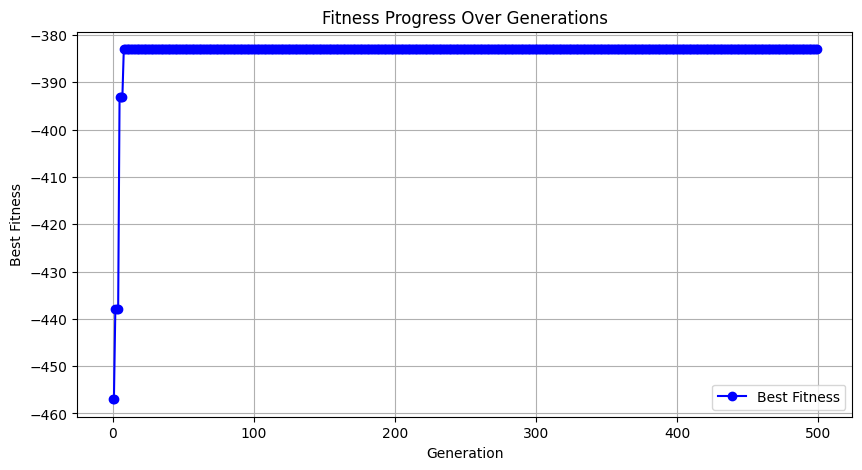

In [232]:
generations = list(range(len(fitness_history)))
plt.figure(figsize=(10, 5))
plt.plot(generations, fitness_history, marker='o', linestyle='-', color='b', label='Best Fitness')

plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Fitness Progress Over Generations")
plt.legend()
plt.grid(True)
plt.show()